<style>
.wzor {
  /* width: auto; */
  /* padding: auto; */
  border: 0.5rem solid gray;
  /* margin: 0; */
  background-color: lightgray;
}
</style>


# Modele analizy danych

### 2024/2025, semestr zimowy
Tomasz Rodak

---

## Literatura
   1. James, G., Witten, D., Hastie, T., Tibshirani, R., & Taylor,
      J. (2023). An Introduction to Statistical Learning: With
      Applications in Python.
      
      [ISLP](https://www.statlearning.com/)
   
   2. Bishop, C. M., & Nasrabadi, N. M. (2006). Pattern recognition and
      machine learning (Vol. 4, No. 4, p. 738). New York: springer. 
   
      [PRML](https://www.microsoft.com/en-us/research/people/cmbishop/prml-book/)
   
   3. Kroese, D. P., Botev, Z., Taimre, T., & Vaisman, R. (2019). Data
      science and machine learning: mathematical and statistical
      methods. CRC Press.
   
      [https://people.smp.uq.edu.au/DirkKroese/DSML/](https://people.smp.uq.edu.au/DirkKroese/DSML/)
   
   4. Hastie, T., Tibshirani, R., Friedman, J. H., & Friedman,
      J. H. (2009). The elements of statistical learning: data mining,
      inference, and prediction (Vol. 2, pp. 1-758). New York:
      springer.
   
      [https://hastie.su.domains/ElemStatLearn/](https://hastie.su.domains/ElemStatLearn/)
   
   5. Murphy, K. P. (2022). Probabilistic machine learning: an
      introduction. MIT press.
   
      [https://probml.github.io/pml-book/book1.html](https://probml.github.io/pml-book/book1.html)
   
   6. Murphy, K. P. (2023). Probabilistic machine learning: Advanced
      topics. MIT press.
   
      [https://probml.github.io/pml-book/book2.html](https://probml.github.io/pml-book/book2.html)
   
   7. Bishop, C. M., & Bishop, H (2024). Deep learning. Springer.
   
      [https://www.bishopbook.com/](https://www.bishopbook.com/)
   
   8. Goodfellow, I., Bengio, Y., & Courville, A. (2016). Deep learning. MIT press.
   
      [https://www.deeplearningbook.org/](https://www.deeplearningbook.org/)

---

## Wykład XII

ISLP, rozdział 6.1

---

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [2]:
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression, Lasso, Ridge

In [3]:
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import StandardScaler

## Selekcja modelu liniowego

Rozważmy klasyczny model liniowy

$$
Y = \beta_0 + \beta_1 X_1 + \ldots + \beta_p X_p + \varepsilon.
$$

Poszukujemy parametrów $\beta_0, \beta_1, \ldots, \beta_p$. Ich estymatory $\hat{\beta}_0, \hat{\beta}_1, \ldots, \hat{\beta}_p$ wyznaczamy na podstawie danych treningowych, zwykle metodą najmniejszych kwadratów.

Celem tego wykładu jest przedstawienie pewnych usprawnień metody najmniejszych kwadratów, pozwalających na

* poprawę jakości predykcji,
* wzrost interpretowalności modelu.

Jeśli relacja między $Y$ a $X_1, \ldots, X_p$ jest naprawdę liniowa a liczba obserwacji $n$ jest duża w porównaniu z $p$, to metoda najmniejszych kwadratów daje dobre predykcje. Obciążenie modelu jest wówczas małe (bo relacja jest naprawdę liniowa) i wariancja jest mała (bo $n\gg p$). Jeśli jednak $n$ nie jest dużo większe od $p$, to sytuacja się pogarsza - metoda najmniejszych kwadratów skutkuje dużą wariancją, i co za tym idzie, przeuczeniem.

Poniżej pokazuję efekt dopasowania modelu liniowego do 5 (lewy wykres) i do 50 (prawy wykres) punktów danych wylosowanych z 

$$
Y = 1 + 2X + \varepsilon,\quad \varepsilon \sim N(0, .3^2).
$$

Punkty generowane są 100 razy. Na wykresie po lewej stronie widać większą wariancję modelu niż na wykresie po prawej. Modele po lewej są przeuczone.

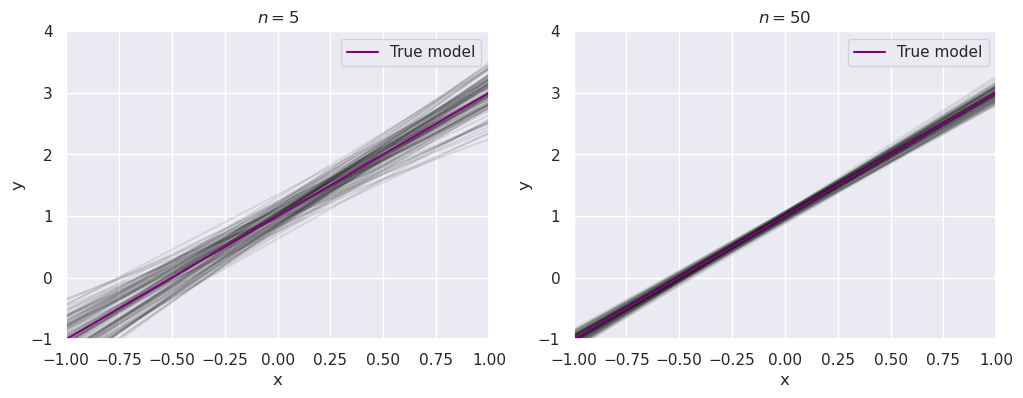

In [4]:
N = 100 # liczba symulacji
n1, n2 = 5, 50 # liczba obserwacji w próbce
rng = np.random.RandomState(42)
x1, x2 = rng.uniform(-1, 1, size=n1), rng.uniform(-1, 1, size=n2) 

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

for _ in range(N):
    eps1, eps2 = rng.normal(scale=.3, size=n1), rng.normal(scale=.3, size=n2)
    y1, y2 = 1 + 2*x1 + eps1, 1 + 2*x2 + eps2
    reg1, reg2 = LinearRegression().fit(x1.reshape(-1, 1), y1), LinearRegression().fit(x2.reshape(-1, 1), y2)
    ax1.axline((0, reg1.intercept_), slope=reg1.coef_[0], color='k', alpha=.1)
    ax2.axline((0, reg2.intercept_), slope=reg2.coef_[0], color='k', alpha=.1)

ax1.axline((0, 1), slope=2, color='purple', label='True model')
ax2.axline((0, 1), slope=2, color='purple', label='True model')
ax1.set(xlabel='x', ylabel='y', xlim=(-1, 1), ylim=(-1, 4), title='$n=5$')
ax2.set(xlabel='x', ylabel='y', xlim=(-1, 1), ylim=(-1, 4), title='$n=50$')
ax1.legend()
ax2.legend();

Sytuacja jest jeszcze gorsza, gdy $p\geqslant n$. Wówczas istnieje nieskończenie wiele wyborów parametrów $\hat{\beta}_0, \hat{\beta}_1, \ldots, \hat{\beta}_p$ dających dokładnie zerowy błąd średniokwadratowy na danych treningowych. Łatwo to zobaczyć w skrajnym przypadku, gdy $p=n=1$ - przez jeden punkt na płaszczyźnie można poprowadzić nieskończenie wiele prostych. Podobnie przez $n$ punktów w przestrzeni $\mathbb{R}^{n+1}$ można poprowadzić nieskończenie wiele hiperpłaszczyzn.

Poniżej przykład 20 obserwacji wylosowanych w 21-wymiarowej przestrzeni. Zmienna celu $Y$ jest niezależna od predyktorów $X_1, \ldots, X_{20}$, które z kolei są niezależne od siebie. Suma kwadratów reszt jest równa 0, model jest idealnie dopasowany do danych treningowych. Jednak oczywiście nie jest to model, który dobrze generalizuje.

In [5]:
p = 20 # liczba predyktorów
n = 20 # liczba obserwacji
rng = np.random.RandomState(42)
X = rng.uniform(0, 1, size=(n, p)) # macierz zmiennych objaśniających
y = rng.normal(size=n) # wektor zmiennej objaśnianej
reg = sm.OLS(y, sm.add_constant(X)).fit() 
print(f'{np.sum(reg.resid**2):.16f}')

0.0000000000000000


Jeden ze sposobów na poradzenie sobie z tym problemem to *regularyzacja*. Termin ten jest ogólny, jednak w przypadku modelu liniowego jest to technika polegająca ograniczeniu zakresu wartości dopasowywanych parametrów $\beta_0, \beta_1, \ldots, \beta_p$. Regularyzacja może nieco pogorszyć dopasowanie modelu do danych treningowych (zwiększyć obciążenie), ale zwykle znacznie poprawia jakość predykcji poprzez zmniejszenie wariancji. Inaczej mówiąc regularyzacja poświęca nieco obciążenia na rzecz zmniejszenia wariancji.

Drugi problem to interpretowalność modelu. Wiadomo, że model liniowy dobrze się interpretuje ze względu na swoją prostotę. Mimo to, interpretacja modelu liniowego może być utrudniona, gdy część predyktorów nie jest związana ze zmienną celu. Usunięcie takich predyktorów - oznaczające w istocie zastąpienie ich parametrów $\beta_j$ zerami - upraszcza model i ułatwia jego interpretację.

### Selekcja predyktorów (*feature selection*, *subset selection*)

#### Selekcja najlepszego układu predyktorów (*best subset selection*)

Metoda polegająca na przeszukaniu **wszystkich** możliwych podzbiorów predyktorów i wybraniu tego, który daje najlepszy, wg. jakiegoś kryterium, model. 

**Algorytm (best subset selection)**

1. $\mathcal{M}_0 = \{\emptyset\}$ jest modelem *zerowym*, nie zawierającym żadnego predyktora. Przewidywanie $\hat{y}$ w tym modelu to średnia ze wszystkich obserwacji treningowych.
2. Dla $k=1, \ldots, p$:
   1. Dopasuj wszystkie modele liniowe zawierające $k$ spośród $p$ predyktorów (jest ich $\binom{p}{k}$). 
   2. Wybierz ten, który daje najmniejszy błąd średniokwadratowy, równoważnie ten o największej wartości $R^2$. Oznacz ten model przez $\mathcal{M}_k$.
3. Wybierz najlepszy model spośród $\mathcal{M}_0, \mathcal{M}_1, \ldots, \mathcal{M}_p$. Tutaj kryterium może być najmniejszy błąd na zbiorze walidacyjnym, największa wartość skorygowanego $R^2$, rezultat kryterium informacyjnego ($C_p$, AIC, BIC, ...).

Jest to algorytm siłowy (*brute force*, *exhaustive search*) - poszukuje rozwiązania przeglądając wszystkie możliwe przypadki. 

Algorytmy siłowe mają istotne zalety:
* zawsze znajdują optymalne rozwiązanie,
* są proste do zrozumienia i zaimplementowania.

Niestety, mają też istotną wadę:
* złożoność obliczeniowa rośnie bardzo szybko wraz ze wzrostem rozmiaru problemu.


Skoro chcemy wyznaczyć najlepszy układ predyktorów metodą przeszukiwania wyczerpującego, to musimy przede wszystkim umieć wszystkie te układy wygenerować. Problem ten sprowadza się do problemu wygenerowania wszystkich podzbiorów zbioru $p$-elementowego. W Pythonie można to zrobić wykorzystując funkcję `combinations()` z modułu `itertools` - funkcja ta generuje wszystkie $k$-elementowe podzbiory ustalonego zbioru. Oto przykład:

In [6]:
from itertools import combinations

list(combinations('ABCD', 3))

[('A', 'B', 'C'), ('A', 'B', 'D'), ('A', 'C', 'D'), ('B', 'C', 'D')]

Zatem wszystkie podzbiory zbioru $p$-elementowego można uzyskać przez wywołanie `combinations(<p-element set>, k)` dla $k=0, 1, \ldots, p + 1$:

In [7]:
[''.join(x) for k in range(5) for x in combinations('ABCD', k)]

['',
 'A',
 'B',
 'C',
 'D',
 'AB',
 'AC',
 'AD',
 'BC',
 'BD',
 'CD',
 'ABC',
 'ABD',
 'ACD',
 'BCD',
 'ABCD']

Poszukamy najlepszego układu predyktorów w problemie regresji liniowej dla danych `Credit`. 

In [8]:
credit = pd.read_csv('datasets/Credit.csv')
credit.head()

,Income,Limit,Rating,Cards,Age,Education,Own,Student,Married,Region,Balance
0,14.891,3606,283,2,34,11,No,No,Yes,South,333
1,106.025,6645,483,3,82,15,Yes,Yes,Yes,West,903
2,104.593,7075,514,4,71,11,No,No,No,West,580
3,148.924,9504,681,3,36,11,Yes,No,No,West,964
4,55.882,4897,357,2,68,16,No,No,Yes,South,331


Zmienną celu jest `Balance`, reszta to predyktory. Część z predyktorów jest kategoryczna, więc kodujemy je do postaci numerycznej, korzystamy z `OneHotEncoder()`, gdyż dane te są binarne lub nie mają porządku:

In [9]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from itertools import combinations

CATEGORICAL = ["Own", "Student", "Married", "Region"]
NUMERICAL = ["Income", "Limit", "Rating", "Cards", "Age", "Education"]

X = credit.drop(columns=["Balance"])

ct = ColumnTransformer(
    transformers=[("ohe", OneHotEncoder(drop="first"), CATEGORICAL)],
    remainder="passthrough",
    verbose_feature_names_out=False
)

X = pd.DataFrame(ct.fit_transform(X), columns=ct.get_feature_names_out())
y = credit["Balance"]

X.head()

,Own_Yes,Student_Yes,Married_Yes,Region_South,Region_West,Income,Limit,Rating,Cards,Age,Education
0,0.0,0.0,1.0,1.0,0.0,14.891,3606.0,283.0,2.0,34.0,11.0
1,1.0,1.0,1.0,0.0,1.0,106.025,6645.0,483.0,3.0,82.0,15.0
2,0.0,0.0,0.0,0.0,1.0,104.593,7075.0,514.0,4.0,71.0,11.0
3,1.0,0.0,0.0,0.0,1.0,148.924,9504.0,681.0,3.0,36.0,11.0
4,0.0,0.0,1.0,1.0,0.0,55.882,4897.0,357.0,2.0,68.0,16.0


Przeszukujemy wszystkie możliwe podzbiory predyktorów (poza zerowym). Dla każdego podzbioru zapamiętujemy wartość $R^2$ i RSS. Jeśli $R^2$ w obrębie ustalonego $k$ wzrosło, to je aktualizujemy. 

In [10]:
PREDICTORS = list(X.columns)

RSS = {n_predictors: [] for n_predictors in range(1, len(PREDICTORS) + 1)}
R2 = {n_predictors: [] for n_predictors in range(1, len(PREDICTORS) + 1)}
best_r2 = len(PREDICTORS) * [0]
best_rss = len(PREDICTORS) * [None]
M_best = [()]
TSS = np.sum((y - y.mean())**2)

for k in range(1, len(PREDICTORS) + 1): # pomijamy model zerowy
    for subset in combinations(PREDICTORS, k):
        X_subset = X[list(subset)]
        reg = LinearRegression().fit(X_subset, y)
        r2 = reg.score(X_subset, y)
        rss = TSS * (1 - r2)
        RSS[k].append(rss)
        R2[k].append(r2)
        
        if r2 > best_r2[k - 1]:
            best_r2[k - 1] = r2
            best_rss[k - 1] = rss
            best_subset = subset
    
    M_best.append(best_subset)

Wykres rozproszenia RSS i $R^2$ w zależności od liczby predyktorów:

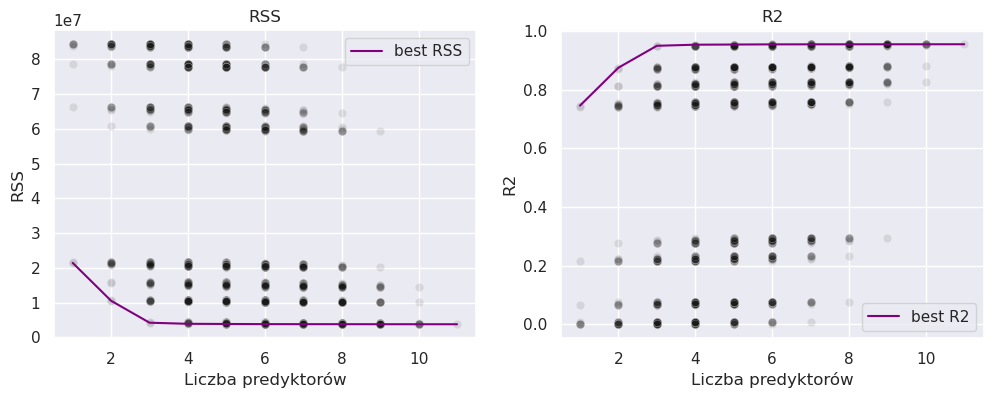

In [11]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

for k in range(1, len(PREDICTORS) + 1):
    x = np.repeat(k, len(RSS[k]))
    sns.scatterplot(x=x, y=RSS[k], ax=ax1, color="k", alpha=.1)
    sns.scatterplot(x=x, y=R2[k], ax=ax2, color="k", alpha=.1)

sns.lineplot(x=range(1, len(PREDICTORS) + 1), y=best_rss,
             ax=ax1, color="purple", label="best RSS")
sns.lineplot(x=range(1, len(PREDICTORS) + 1), y=best_r2,
                ax=ax2, color="purple", label="best R2")

ax1.set(xlabel="Liczba predyktorów", ylabel="RSS", title="RSS")
ax2.set(xlabel="Liczba predyktorów", ylabel="R2", title="R2");

Widać szybką poprawę jakości modelu wraz ze wzrostem liczby predyktorów od jednego do trzech. Dla trzech predyktorów lub więcej wykresy są już płaskie, poprawa jakości modelu jest niewielka.

Najlepsze modele dla kolejnych podzbiorów to:

In [12]:
for k in range(len(PREDICTORS) + 1):
    print(f"k = {k:>2}: {M_best[k]}")

k =  0: ()
k =  1: ('Rating',)
k =  2: ('Income', 'Rating')
k =  3: ('Student_Yes', 'Income', 'Rating')
k =  4: ('Student_Yes', 'Income', 'Limit', 'Cards')
k =  5: ('Student_Yes', 'Income', 'Limit', 'Rating', 'Cards')
k =  6: ('Student_Yes', 'Income', 'Limit', 'Rating', 'Cards', 'Age')
k =  7: ('Own_Yes', 'Student_Yes', 'Income', 'Limit', 'Rating', 'Cards', 'Age')
k =  8: ('Own_Yes', 'Student_Yes', 'Region_West', 'Income', 'Limit', 'Rating', 'Cards', 'Age')
k =  9: ('Own_Yes', 'Student_Yes', 'Married_Yes', 'Region_West', 'Income', 'Limit', 'Rating', 'Cards', 'Age')
k = 10: ('Own_Yes', 'Student_Yes', 'Married_Yes', 'Region_South', 'Region_West', 'Income', 'Limit', 'Rating', 'Cards', 'Age')
k = 11: ('Own_Yes', 'Student_Yes', 'Married_Yes', 'Region_South', 'Region_West', 'Income', 'Limit', 'Rating', 'Cards', 'Age', 'Education')


### Metoda schodów (*stepwise selection*)

#### Metoda schodów wstępujących (*forward stepwise selection*)

Startujemy od modelu zerowego, który nie zawiera żadnego predyktora. W każdym kroku dodajemy do modelu jeden predyktor, wybierając ten najlepszy spośród niewykorzystanych dotąd. W każdym kroku model jest rozbudowywany o jeden predyktor, aż do osiągnięcia ustalonej liczby predyktorów lub do osiągnięcia ustalonego kryterium.

**Algorytm (forward stepwise selection)**
1. $\mathcal{M}_0 = \{\emptyset\}$ jest modelem *zerowym*, nie zawierającym żadnego predyktora. Przewidywanie $\hat{y}$ w tym modelu to średnia ze wszystkich obserwacji treningowych.
2. Dla $k=0, \ldots, p-1$:
   1. Dopasuj $p-k$ modeli uzupełniających predyktory w $\mathcal{M}_k$ o jeden predyktor spośród $p-k$ niewykorzystanych dotąd.
   2. Wybierz najlepszy spośród tych $p-k$ modeli. W przypadku regresji liniowej może to być model o najmniejszym błędzie średniokwadratowym, równoważnie o największym $R^2$. Oznacz ten model przez $\mathcal{M}_{k+1}$.
3. Wybierz najlepszy model spośród $\mathcal{M}_0, \mathcal{M}_1, \ldots, \mathcal{M}_p$. Tutaj kryterium może być najmniejszy błąd na zbiorze walidacyjnym, największa wartość skorygowanego $R^2$, rezultat kryterium informacyjnego ($C_p$, AIC, BIC, ...).

Implementacja algorytmu przeszukiwania wstępującego:

In [13]:
M_forward = [()] # lista modeli

for k in range(len(PREDICTORS)):
    used = M_forward[-1]
    candidates = [(*used, predictor) for predictor in PREDICTORS if predictor not in used]
    best_r2 = 0
    for candidate in candidates:
        X_subset = X[list(candidate)]
        reg = LinearRegression().fit(X_subset, y)
        r2 = reg.score(X_subset, y)
        if r2 > best_r2:
            best_r2 = r2
            best_candidate = candidate
    M_forward.append(best_candidate)

Kolejne układy predyktorów:

In [14]:
for k in range(len(PREDICTORS) + 1):
    print(f"k = {k:>2}: {M_forward[k]}")

k =  0: ()
k =  1: ('Rating',)
k =  2: ('Rating', 'Income')
k =  3: ('Rating', 'Income', 'Student_Yes')
k =  4: ('Rating', 'Income', 'Student_Yes', 'Limit')
k =  5: ('Rating', 'Income', 'Student_Yes', 'Limit', 'Cards')
k =  6: ('Rating', 'Income', 'Student_Yes', 'Limit', 'Cards', 'Age')
k =  7: ('Rating', 'Income', 'Student_Yes', 'Limit', 'Cards', 'Age', 'Own_Yes')
k =  8: ('Rating', 'Income', 'Student_Yes', 'Limit', 'Cards', 'Age', 'Own_Yes', 'Region_West')
k =  9: ('Rating', 'Income', 'Student_Yes', 'Limit', 'Cards', 'Age', 'Own_Yes', 'Region_West', 'Married_Yes')
k = 10: ('Rating', 'Income', 'Student_Yes', 'Limit', 'Cards', 'Age', 'Own_Yes', 'Region_West', 'Married_Yes', 'Region_South')
k = 11: ('Rating', 'Income', 'Student_Yes', 'Limit', 'Cards', 'Age', 'Own_Yes', 'Region_West', 'Married_Yes', 'Region_South', 'Education')


Porównanie z najlepszymi układami predyktorów wyznaczonymi metodą przeszukiwania wyczerpującego:

In [15]:
for k in range(len(PREDICTORS) + 1):
    # symmetric difference
    symmetric_difference = set(M_forward[k]) ^ set(M_best[k])
    if len(symmetric_difference) == 0:
        print(f"k = {k:>2}: brak różnic")
    else:
        print(f"k = {k:>2}: {symmetric_difference}")

k =  0: brak różnic
k =  1: brak różnic
k =  2: brak różnic
k =  3: brak różnic
k =  4: {'Cards', 'Rating'}
k =  5: brak różnic
k =  6: brak różnic
k =  7: brak różnic
k =  8: brak różnic
k =  9: brak różnic
k = 10: brak różnic
k = 11: brak różnic


### Metoda schodów opadających (*backward stepwise selection*)

Startujemy od modelu zawierającego wszystkie predyktory. W każdym kroku rozważamy wszystkie możliwe modele, które powstają przez usunięcie jednego predyktora z aktualnego modelu. Wybieramy ten, który jest najlepszy, w przypadku regresji liniowej może to być model o najmniejszym RSS, równoważnie o największym $R^2$. W każdym kroku model jest zmniejszany o jeden predyktor, aż do osiągnięcia ustalonej liczby predyktorów lub do osiągnięcia ustalonego kryterium.

**Algorytm (backward stepwise selection)**
1. $\mathcal{M}_p = \{X_1, \ldots, X_p\}$ jest modelem zawierającym wszystkie predyktory.
2. Dla $k=p, \ldots, 1$:
   1. Rozważ wszystkie $k$ modeli powstałych przez usunięcie jednego predyktora z $\mathcal{M}_k$.
   2. Wybierz spośród nich najlepszy. W przypadku regresji liniowej może to być model o najmniejszym RSS, równoważnie o największym $R^2$. Oznacz ten model przez $\mathcal{M}_{k-1}$.
3. Wybierz najlepszy model spośród $\mathcal{M}_0, \mathcal{M}_1, \ldots, \mathcal{M}_p$. Kryterium może być najmniejszy błąd na zbiorze walidacyjnym, największa wartość skorygowanego $R^2$, rezultat kryterium informacyjnego ($C_p$, AIC, BIC, ...).

Implementacja algorytmu przeszukiwania opadającego:

In [16]:
M_backward = [tuple(PREDICTORS)] # lista modeli

for k in range(len(PREDICTORS), 1, -1):
    used = M_backward[-1]
    candidates = [used[:i] + used[i + 1:] for i in range(len(used))]
    best_r2 = 0
    for candidate in candidates:
        X_subset = X[list(candidate)]
        reg = LinearRegression().fit(X_subset, y)
        r2 = reg.score(X_subset, y)
        if r2 > best_r2:
            best_r2 = r2
            best_candidate = candidate
    M_backward.append(best_candidate)

M_backward.append(())

Kolejne układy predyktorów:

In [17]:
for k in range(len(PREDICTORS) + 1):
    print(f"n = {k:>2}: {M_backward[k]}")

n =  0: ('Own_Yes', 'Student_Yes', 'Married_Yes', 'Region_South', 'Region_West', 'Income', 'Limit', 'Rating', 'Cards', 'Age', 'Education')
n =  1: ('Own_Yes', 'Student_Yes', 'Married_Yes', 'Region_South', 'Region_West', 'Income', 'Limit', 'Rating', 'Cards', 'Age')
n =  2: ('Own_Yes', 'Student_Yes', 'Married_Yes', 'Region_West', 'Income', 'Limit', 'Rating', 'Cards', 'Age')
n =  3: ('Own_Yes', 'Student_Yes', 'Region_West', 'Income', 'Limit', 'Rating', 'Cards', 'Age')
n =  4: ('Own_Yes', 'Student_Yes', 'Income', 'Limit', 'Rating', 'Cards', 'Age')
n =  5: ('Student_Yes', 'Income', 'Limit', 'Rating', 'Cards', 'Age')
n =  6: ('Student_Yes', 'Income', 'Limit', 'Rating', 'Cards')
n =  7: ('Student_Yes', 'Income', 'Limit', 'Cards')
n =  8: ('Student_Yes', 'Income', 'Limit')
n =  9: ('Income', 'Limit')
n = 10: ('Limit',)
n = 11: ()


Porównanie trzech metod selekcji predyktorów:

In [18]:
for k in range(len(PREDICTORS) + 1):
    j = len(PREDICTORS) - k
    symmetric_difference = set(M_backward[j]) ^ set(M_best[k])
    if len(symmetric_difference) == 0:
        print(f"k = {k:>2}: brak różnic")
    else:
        print(f"k = {k:>2}: {symmetric_difference}")

k =  0: brak różnic
k =  1: {'Limit', 'Rating'}
k =  2: {'Limit', 'Rating'}
k =  3: {'Limit', 'Rating'}
k =  4: brak różnic
k =  5: brak różnic
k =  6: brak różnic
k =  7: brak różnic
k =  8: brak różnic
k =  9: brak różnic
k = 10: brak różnic
k = 11: brak różnic


### Wybór optymalego modelu

W obrębie ustalonej liczby predyktorów wybieraliśmy ten model, który dawał najmniejszy RSS, równoważnie największy $R^2$. Łatwo jednak zauważyć, że RSS będzie zawsze maleć wraz ze wzrostem liczby predyktorów.
Ponadto RSS jest miarą, która odpowiada błędowi treningowemu, podczas gdy to co nas interesuje, to błąd testowy, gdyż to on decyduje o zdolności modelu do generalizacji.

Błąd testowy na ogół jest nieznany, możemy go jednak próbować oszacować. 

Z grubsza mamy dwa możliwe podejścia:
1. Dostowanie błędu trenigowego, przez uwzględnienie zmieniającej się złożoności modelu. 
2. Bezpośrednie oszacowanie błędu testowego na zbiorze walidacyjnym lub poprzez kroswalidację.

#### Statystyka Mallowa $C_p$

Statystykę Mallowa $C_p$ definiujemy wzorem

$$
C_p = \frac{1}{n} \left( RSS + 2d\hat{\sigma}^2 \right),
$$

gdzie $d$ to liczba parametrów modelu, $\hat{\sigma}^2$ to estymator wariancji błędu $\varepsilon$:

$$
\hat{\sigma}^2 = \frac{1}{n-p-1} RSS.
$$

Wartość $\hat{\sigma}^2$ szacujemy na danych treningowych wykorzystując pełen model, tzn. model zawierający wszystkie predyktory.



#### Kryteria informacyjne AIC, BIC

Kryterium informacyjne Akaikego (AIC) i kryterium informacyjne Bayesa (BIC) definujemy dla modeli, w których uczenie odbywa się poprzez maksymalizację funkcji wiarygodności. AIC dla modelu liniowego ma dwie postacie, z których jedna jest proporcjonalna do $C_p$. BIC w modelu liniowym, z dokładnością do stałej proporcjonalności, jest zdefiniowane wzorem

\begin{equation*}
BIC = \frac{1}{n} \left( RSS + \log(n) d \hat{\sigma}^2 \right).
\end{equation*}

Ponieważ $\log(n) > 2$ dla $n>7$, to BIC nakłada większą karę na złożoność modelu niż AIC.

#### Skorygowany współczynnik determinacji $R^2$

Skorygowany współczynnik determinacji $R^2$ (*adjusted $R^2$*) to współczynnik $R^2$ skorygowany o efekt związany z liczbą predyktorów. W modelu liniowym jest zdefiniowany wzorem

\begin{equation*}
\text{adjusted } R^2 = 1 - \frac{RSS/(n-p-1)}{TSS/(n-1)},
\end{equation*}

gdzie $TSS = \sum_{i=1}^n (y_i - \bar{y})^2$ to suma kwadratów odchyleń obserwacji od średniej.

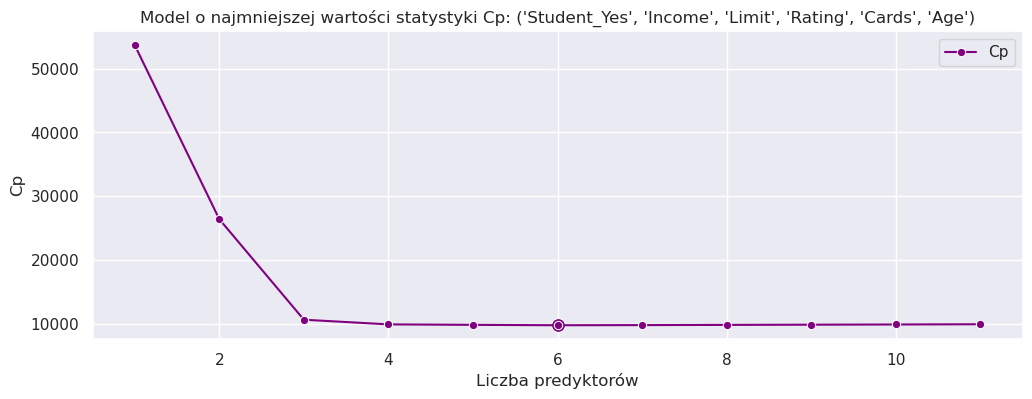

In [19]:
n = len(y)
p = len(PREDICTORS)
full_model = LinearRegression().fit(X, y)
RSS = np.sum((y - full_model.predict(X)) ** 2)
hat_sigma_squared = RSS / (n - p - 1)
Cp_stats = []

M = M_best  # Lista modeli

for predictors in M[1:]:
    X_subset = X[list(predictors)]
    reg = LinearRegression().fit(X_subset, y)
    rss = np.sum((y - reg.predict(X_subset)) ** 2)
    d = len(predictors)
    Cp = (rss + 2 * d * hat_sigma_squared) / n  # Statystyka Cp
    Cp_stats.append(Cp)

best_index = np.argmin(Cp_stats)
best_subset = M[best_index + 1]

fig, ax = plt.subplots(figsize=(12, 4))
sns.lineplot(
    x=range(1, len(PREDICTORS) + 1), y=Cp_stats, color="purple", label="Cp", marker="o", ax=ax
)
sns.scatterplot(
    x=[best_index + 1], y=[Cp_stats[best_index]], color="purple", marker="o", s=100, ax=ax
)
ax.set(
    xlabel="Liczba predyktorów", 
    ylabel="Cp",
    title=f"Model o najmniejszej wartości statystyki Cp: {best_subset}"
    );

## Regularyzacja

### Regresja grzbietowa (*ridge regression*)

Rozważmy klasyczny model liniowy

$$
Y = \beta_0 + \beta_1 X_1 + \ldots + \beta_p X_p + \varepsilon.
$$

Poszukujemy parametrów $\beta_0, \beta_1, \ldots, \beta_p$. Ich estymatory $\hat{\beta}_0, \hat{\beta}_1, \ldots, \hat{\beta}_p$ wyznaczamy na podstawie danych treningowych. Jeśli stosujemy metodę najmniejszych kwadratów, to minimalizujemy względem $\beta_0, \beta_1, \ldots, \beta_p$ funkcję

$$
\text{RSS}(\beta) = \sum_{i=1}^n \left( y_i - \beta_0 - \sum_{j=1}^p \beta_j x_{ij} \right)^2.
$$

Model regresji grzbietowej (*ridge regression*) jest podobny, ale narzuca dodatkowe ograniczenie na parametry $\beta_1, \ldots, \beta_p$. W tym nowym przypadku minimalizujemy względem $\beta_0, \beta_1, \ldots, \beta_p$ funkcję postaci

$$
\text{RSS}(\beta) + \lambda \sum_{j=1}^p \beta_j^2,
$$

gdzie $\lambda \geq 0$ jest ustalonym parametrem. Jeśli $\lambda = 0$, to otrzymujemy klasyczny model liniowy. Jeśli $\lambda > 0$, to otrzymujemy model regresji grzbietowej, w tym przypadku optymalne parametry $\beta_0, \beta_1, \ldots, \beta_p$ będą inne niż w klasycznym modelu liniowym.

**Ważne:** w modelu regresji grzbietowej nie narzuca się ograniczeń na $\beta_0$. 

W przypadku zwykłej regresji liniowej estymatory $\hat{\beta}_1, \ldots, \hat{\beta}_p$ skalują się zgodnie z wartościami predyktorów $X_1, \ldots, X_p$: zamiana $X_j$ na $cX_j$ skutkuje zamianą $\hat{\beta}_j$ na $\hat{\beta}_j/c$. Analogicznej zależności nie ma w modelu regresji grzbietowej i z tego powodu zaleca się w tym przypadku standaryzację predyktorów. 

Standaryzacja polega na przekształceniu zmiennych $X_1, \ldots, X_p$ na zmienne $X_1^*, \ldots, X_p^*$ postaci

\begin{equation*}
X_j^* = \frac{X_j - \bar{X}_j}{s_j},
\end{equation*}

gdzie $\bar{X}_j$ to średnia wartość $j$-tego predyktora, $s_j$ to odchylenie standardowe $j$-tego predyktora:

\begin{equation*}
\bar{X}_j = \frac{1}{n} \sum_{i=1}^n X_{ij},\quad s_j = \sqrt{\frac{1}{n} \sum_{i=1}^n (X_{ij} - \bar{X}_j)^2}.
\end{equation*}

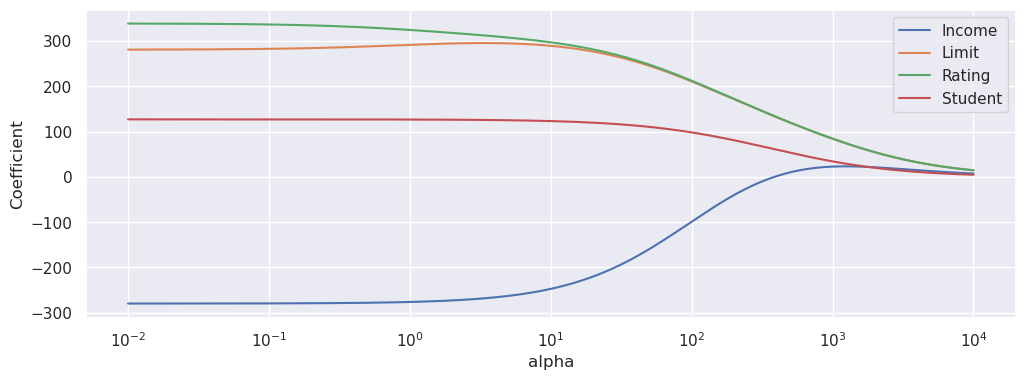

In [20]:
X = credit.loc[:, ['Income', 'Limit', 'Rating']]
X.loc[:, 'Student'] = credit['Student'].map({'Yes': 1, 'No': 0})
y = credit['Balance']
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

alphas = np.geomspace(1e-2, 1e4, 500)
params = []

for alpha in alphas:
    reg = Ridge(alpha=alpha).fit(X_scaled, y)
    params.append(reg.coef_.tolist())

params = pd.DataFrame(params, columns=X.columns)
params['alpha'] = alphas

fig, ax = plt.subplots(figsize=(12, 4))
for col in params.columns[:-1]:
    ax.plot(params['alpha'], params[col], label=col)
ax.set_xscale('log')
ax.set_xlabel('alpha')
ax.set_ylabel('Coefficient')
ax.legend();

### Regresja LASSO (*least absolute shrinkage and selection operator*)

Model regresji LASSO jest podobny do regresji grzbietowej, ale zamiast dodawać do funkcji RSS karę w postaci sumy kwadratów parametrów, dodaje się sumę wartości bezwzględnych:

\begin{equation*}
\text{RSS}(\beta) + \lambda \sum_{j=1}^p |\beta_j|.
\end{equation*}

Podoobnie jak wcześniej, $\lambda \geq 0$ jest ustalonym parametrem. Na parametr $\beta_0$ nie nakłada się żadnych ograniczeń.

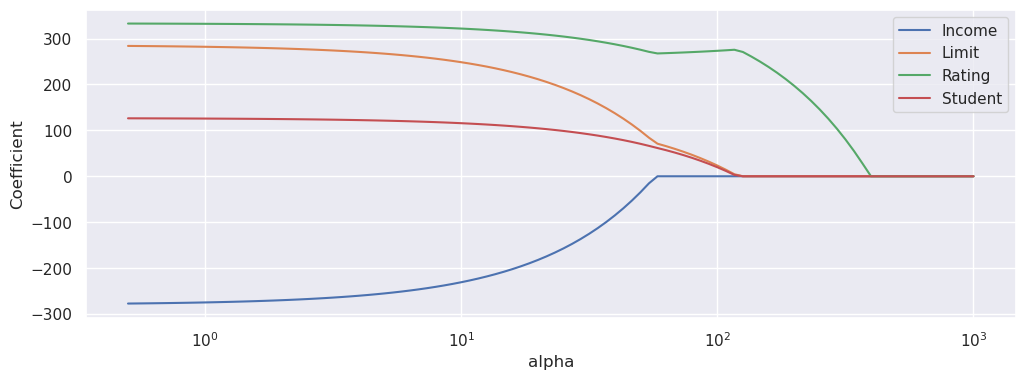

In [21]:
X = credit.loc[:, ['Income', 'Limit', 'Rating']]
X.loc[:, 'Student'] = credit['Student'].map({'Yes': 1, 'No': 0})
y = credit['Balance']
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

alphas = np.geomspace(.5, 1e3, 100)
params = []

for alpha in alphas:
    reg = Lasso(alpha=alpha).fit(X_scaled, y)
    params.append(reg.coef_.tolist())
    
params = pd.DataFrame(params, columns=X.columns)
params['alpha'] = alphas

fig, ax = plt.subplots(figsize=(12, 4))
for col in params.columns[:-1]:
    ax.plot(params['alpha'], params[col], label=col)
ax.set_xscale('log')
ax.set_xlabel('alpha')
ax.set_ylabel('Coefficient')
ax.legend();

### Alternatywne definicja regresji Ridge i LASSO

Można pokazać, że regresja grzbietowa jest równoważna minimalizacji $\text{RSS}(\beta)$ przy ograniczeniu $\sum_{j=1}^p \beta_j^2 \leq s$, gdzie $s$ jest ustalonym parametrem:

\begin{equation*}
\operatorname{argmin}_{\beta} \sum_{i=1}^n \left( y_i - \beta_0 - \sum_{j=1}^p \beta_j x_{ij} \right)^2 \quad \text{przy ograniczeniu} \quad \sum_{j=1}^p \beta_j^2 \leq s.
\end{equation*}

Dokładniej, oznacza to, że regresja grzbietowa z ustalonym $\lambda$ jest równoważna zdefiniowanej powyżej minimalizacji przy pewnym $s$ i odwrotnie.

Podobnie, regresja LASSO jest równoważna minimalizacji $\text{RSS}(\beta)$ przy ograniczeniu $\sum_{j=1}^p |\beta_j| \leq s$:

\begin{equation*}
\operatorname{argmin}_{\beta} \sum_{i=1}^n \left( y_i - \beta_0 - \sum_{j=1}^p \beta_j x_{ij} \right)^2 \quad \text{przy ograniczeniu} \quad \sum_{j=1}^p |\beta_j| \leq s.
\end{equation*}

Ujęcie to ma ciekawą konsekwencję. Parametr $s$ możemy traktować jako *budżet* przeznaczony na parametry modelu. Jeśli parametry $\hat{\beta}_1, \ldots, \hat{\beta}_p$ nie przekraczają budżetu $s$, tzn. $\sum_{j=1}^p \hat{\beta}_j^2 \leq s$ w przypadku regresji grzbietowej lub $\sum_{j=1}^p |\hat{\beta}_j| \leq s$ w przypadku regresji LASSO, to otrzymujemy model taki sam jak w klasycznym przypadku liniowym. W przeciwnym razie otrzymujemy model o parametrach $\hat{\beta}_1, \ldots, \hat{\beta}_p$ dających punkt na granicy budżetu $s$: $\sum_{j=1}^p \hat{\beta}_j^2 = s$ w przypadku regresji grzbietowej lub $\sum_{j=1}^p |\hat{\beta}_j| = s$ w przypadku regresji LASSO. Będzie to ten punkt, w którym hiperpowierzchnia stałego RSS dotyka w jednym punkcie hiperpowierzchnię ograniczeń. Ponieważ dla regresji LASSO hiperpowierzchnia ograniczeń ma kształt hipersześcianu, więc punkt ten na ogół leży na jednej z niżej wymiarowych ścian. Ściany te jednak są zawarte w podukładach osi układu współrzędnych, więc punkt ten jest na ogół rzadki, tzn. ma wiele zerowych współrzędnych.

<div class="wzor">

**Wniosek:** regresja LASSO ma wbudowany mechanizm selekcji predyktorów. 

</div>